# Research Question 1

### How well does a region's partisan lean predict the level of primary support for the winning candidate? 

In order to analyze this question we need to define what the question is specfically asking. A region's partisan level represents the average difference between how a state or district voted in the past two presidential elections and how the country voted overall, or in other words a region's relative political extremity. Primary support represents what percent of votes in the region go to a candidate in the primary election. To answer this question we need to look at the quantitiative relationship between the two, meaning that either GLMs or Non-Parametric models will allow us to answer our question. Within Non-Parametric models we are restricted to using those which allow for continuous outputs so we can use Neural Networks or K Nearest Neighbors. To use these models we need to ensure we are using the correct features and provided in the dataset is a long list of primarily categorical features pertaining to the candidate or the election the candidate is running in. As part of our EDA the biggest problem that we hypothesized is correctly representing the necessary features to accurately represent the traits of candidates in our analysis. This part of the analysis is vital because if a critical feature is not included in our analysis which has severe effects on election outcomes it could render the entire model useless. Shown below is our analysis and interpretation of relevant features and their impact on election outcomes.

In [2]:
import pandas as pd
import numpy as np
import difflib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

/shared-libs/python3.10/py/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-12 04:41:13.096065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 04:41:13.367493: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-12 04:41:13.367549: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-1

# EDA

In [3]:
#imports election/candidate data
dem = pd.read_csv('dem_candidates.csv')
rep = pd.read_csv('rep_candidates.csv')
#imports female candidate names
female = pd.read_csv('/work/Gender_2.csv')
#extracts first and last names of candidates
dem.loc[:, ["first_name", "last_name"]] = dem["Candidate"].str.replace('(\s([("].+[)"]))|(\s\w+\.)', "") \
                            .str.split(" ").apply(lambda names: [names[0], names[-1]]).to_list()
#checks which name combinations are found in the female dataset
dem["is_female"] = np.where(dem.apply(lambda row: any(female["Name"].str.contains(f"({row['first_name']}).*({row['last_name']})")), axis=1), "Yes", "No")
dem

/tmp/ipykernel_85/2379942949.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  dem.loc[:, ["first_name", "last_name"]] = dem["Candidate"].str.replace('(\s([("].+[)"]))|(\s\w+\.)', "") \
/shared-libs/python3.10/py/lib/python3.10/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?,first_name,last_name,is_female
0,Anthony White (Alabama),AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Anthony,White,No
1,Christopher Countryman,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Christopher,Countryman,No
2,"Doug ""New Blue"" Smith",AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Doug,Smith,No
3,James C. Fields,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,James,Fields,No
4,Sue Bell Cobb,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sue,Cobb,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,Talley Sergent,WV,U.S. House West Virginia District 2,Representative,Regular,5/8/18,Advanced,None,On the Ballot,-35.330002,...,NaN,NaN,NaN,NaN,NaN,No,NaN,Talley,Sergent,No
807,Janice Hagerman,WV,U.S. House West Virginia District 3,Representative,Regular,5/8/18,Lost,None,None,-47.480000,...,NaN,NaN,NaN,NaN,No,No,NaN,Janice,Hagerman,No
808,Paul Davis,WV,U.S. House West Virginia District 3,Representative,Regular,5/8/18,Lost,None,None,-47.480000,...,NaN,NaN,NaN,NaN,No,No,NaN,Paul,Davis,No
809,Richard Ojeda,WV,U.S. House West Virginia District 3,Representative,Regular,5/8/18,Advanced,None,On the Ballot,-47.480000,...,NaN,NaN,NaN,NaN,Yes,Yes,NaN,Richard,Ojeda,No


In [4]:
#creates sub dataframe of only primary winning candidates
win_dem = dem.loc[dem["Won Primary"] == 'Yes']
#removes candidates running unopposed
win_dem = win_dem.loc[win_dem["Primary %"] != 100]
#removes missing info for relevant features
win_dem.dropna(subset=['Partisan Lean', 'Primary %'],inplace=True)

In [5]:
win_rep = rep.loc[rep["Won Primary"] == 'Yes']
win_rep = win_rep.loc[win_rep["Primary %"] != 100]
win_rep.dropna(subset= ['Primary %'],inplace=True)

Text(0.5, 1.0, 'Distribution of Winning Primary Support')

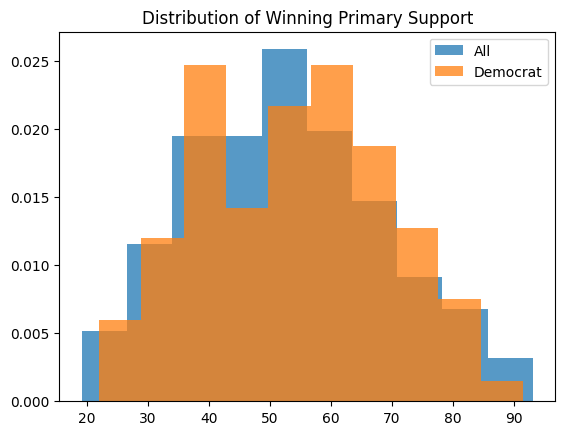

In [27]:
all_win = pd.concat([win_dem, win_rep])
plt.hist(all_win["Primary %"], density=True, alpha=0.75, label="All")
plt.hist(win_dem["Primary %"], density=True, alpha=0.75, label="Democrat")
#sns.histplot(x="Primary %", data=all_win, stat="density")
#sns.histplot(x="Primary %", data=win_dem, stat="density")
plt.legend()
plt.title("Distribution of Winning Primary Support")

In [46]:

win_rep

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Primary %,...,NRA Endorsed?,Right to Life Endorsed?,Susan B. Anthony Endorsed?,Club for Growth Endorsed?,Koch Support?,House Freedom Support?,Tea Party Endorsed?,Main Street Endorsed?,Chamber Endorsed?,No Labels Support?
0,Mike Dunleavy,AK,Governor of Alaska,Governor,Regular,8/21/18,Advanced,None,On the Ballot,61.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Wendy Rogers,AZ,U.S. House Arizona District 1,Representative,Regular,8/28/18,Advanced,None,On the Ballot,43.40,...,NaN,NaN,NaN,No,NaN,NaN,No,NaN,NaN,NaN
10,Lea Marquez Peterson,AZ,U.S. House Arizona District 2,Representative,Regular,8/28/18,Advanced,None,On the Ballot,33.60,...,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN
16,Nicolas Pierson,AZ,U.S. House Arizona District 3,Representative,Regular,8/28/18,Advanced,None,On the Ballot,51.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,Debbie Lesko,AZ,U.S. House Arizona District 8,Representative,Special,2/27/18,Advanced,None,On the Ballot,35.77,...,NaN,NaN,Yes,NaN,Yes,Yes,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,Patrick Morrisey,WV,U.S. Senate West Virginia,Senator,Regular,5/8/18,Advanced,None,On the Ballot,34.90,...,NaN,NaN,NaN,NaN,Yes,NaN,Yes,No,NaN,NaN
754,Bryan Steil,WI,U.S. House Wisconsin District 1,Representative,Regular,8/14/18,Advanced,None,On the Ballot,51.60,...,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
761,Tim Rogers,WI,U.S. House Wisconsin District 4,Representative,Regular,8/14/18,Advanced,None,On the Ballot,55.60,...,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
763,Leah Vukmir,WI,U.S. Senate Wisconsin,Senator,Regular,8/14/18,Advanced,None,On the Ballot,49.00,...,Yes,Yes,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN


## Data Visualization

### Figure 1

Text(0.5, 1.0, 'Partisan Lean vs. Primary Support by Office')

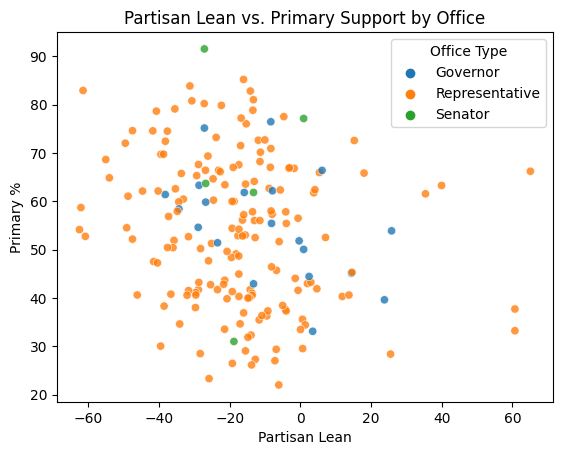

In [ ]:
sns.scatterplot(x=win_dem["Partisan Lean"], y=win_dem["Primary %"], hue=win_dem["Office Type"], alpha=0.8)
plt.title("Partisan Lean vs. Primary Support by Office")

Text(0.5, 1.0, 'Partisan Lean vs. Primary Support by Veteran Status')

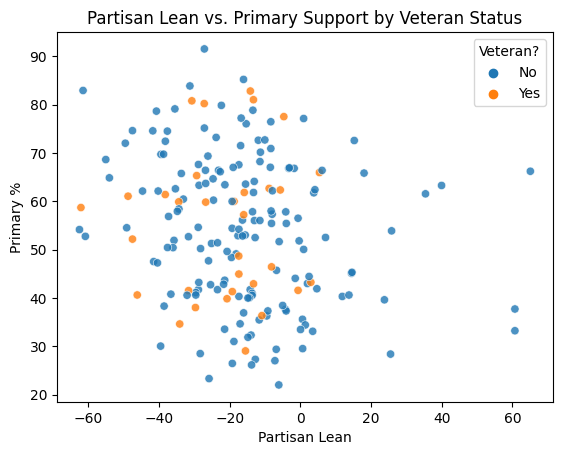

In [ ]:
sns.scatterplot(x=win_dem["Partisan Lean"], y=win_dem["Primary %"], hue=win_dem["Veteran?"], alpha=0.8)
plt.title("Partisan Lean vs. Primary Support by Veteran Status")

### Figure 2

Text(0.5, 1.0, 'Partisan Lean vs. Primary Support by Office Status')

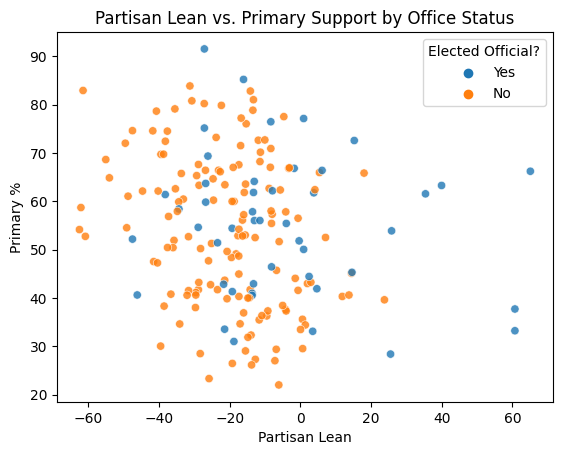

In [ ]:
sns.scatterplot(x=win_dem["Partisan Lean"], y=win_dem["Primary %"], hue=win_dem["Elected Official?"], alpha=0.8)
plt.title("Partisan Lean vs. Primary Support by Office Status")

Text(0.5, 1.0, 'Partisan Lean vs. Primary Support by Group')

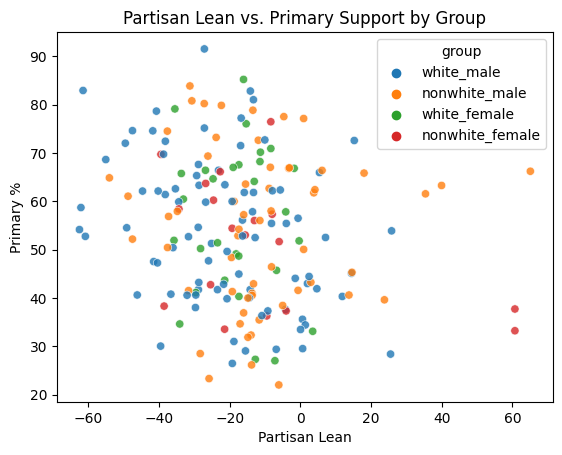

In [ ]:
def race_female(race, female):
    if race=='White':
        if female == 'Yes':
            return "white_female"
        else:
            return "white_male"
    else:
        if female=='Yes':
            return "nonwhite_female"
        else:
            return "nonwhite_male"
win_dem["group"] = win_dem[["Race", "is_female"]].apply(lambda x: race_female(x["Race"], x["is_female"]), axis=1)
sns.scatterplot(data=win_dem, x="Partisan Lean", y="Primary %", hue="group", alpha=0.8)
plt.title("Partisan Lean vs. Primary Support by Group")

In [ ]:
win_dem_grps = win_dem.rename({'Partisan Lean':'partisan_lean', 'Primary %':'primary', 'Elected Official?':'elected_official'}, axis=1)
win_dem_grps["is_female"] = np.where(win_dem_grps["is_female"].values == "Yes", 1, 0)
win_dem_grps["is_nonwhite"] = np.where(win_dem_grps["Race"] == "Nonwhite", 1, 0)
win_dem_grps["elected_official"] = np.where(win_dem_grps["elected_official"].values == "Yes", 1, 0)
X_glm = win_dem_grps[['partisan_lean', 'is_female', 'is_nonwhite', 'elected_official']]
y_glm = win_dem_grps['primary']
train, test = train_test_split(win_dem_grps, test_size=0.2, random_state=42)
glm_model = smf.ols(formula="primary ~ partisan_lean * is_nonwhite + partisan_lean * is_female + partisan_lean * elected_official", data=train).fit(cov_type="HC0")
glm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                primary   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     3.261
Date:                Mon, 11 Dec 2023   Prob (F-statistic):            0.00303
Time:                        21:03:31   Log-Likelihood:                -625.25
No. Observations:                 153   AIC:                             1267.
Df Residuals:                     145   BIC:                             1291.
Df Model:                           7                                         
Covariance Type:                  HC0                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         51.7138      2.355     21.963      0.000      47.099      56.329
partisan_lean                     -0.2291      0.076     -3.025      0.002      -0.378      -0.081
is_nonwhite                       -2.6824      3.010     -0.891      0.373      -8.581       3.216
partisan_lean:is_nonwhite          0.0963      0.113      0.852      0.394      -0.125       0.318
is_female                         -5.6291      2.806     -2.006      0.045     -11.128      -0.130
partisan_lean:is_female           -0.2251      0.097     -2.330      0.020      -0.414      -0.036
elected_official                   7.4248      3.017      2.461      0.014       1.511      13.339
partisan_lean:elected_official     0.2238      0.116      1.930      0.054      -0.003       0.451
==============================================================================
Omnibus:                        8.000   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                3.643
Skew:                           0.047   Prob(JB):                        0.162
Kurtosis:                       2.250   Cond. No.                         98.9
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

Text(0.5, 1.0, 'Sample Primary Support Predictions By Group, Private Citizens')

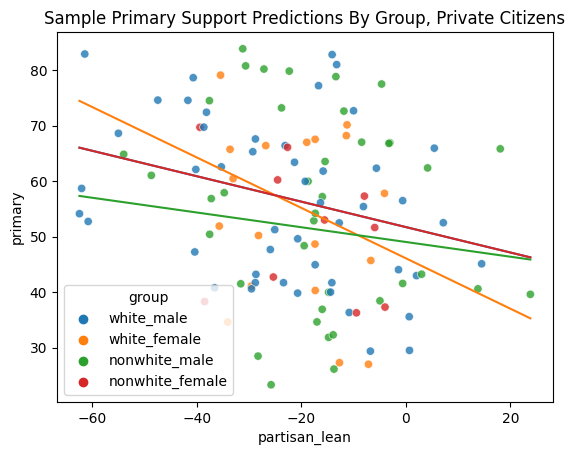

In [ ]:
x = np.linspace(train["partisan_lean"].loc[train["elected_official"]==0].min(),
             train["partisan_lean"].loc[train["elected_official"]==0].max(), 100)
line_df = pd.DataFrame({"partisan_lean":x, "is_nonwhite":np.zeros(100), 
                        "is_female":np.zeros(100), "group":"white_male",
                        "elected_official":np.zeros(100)})
groups = ["white_male", "white_female", "nonwhite_male", "nonwhite_female"]
for i in range(2,5):
    temp_line_df = line_df.iloc[:100,].copy()
    temp_line_df.loc[:, "is_nonwhite"] = np.zeros(100) if i%2 == 0 else np.ones(100)
    temp_line_df.loc[:, "is_female"] = np.zeros(100) if i > 2 else np.ones(100)
    temp_line_df.loc[:, "elected_official"] = np.zeros(100)
    temp_line_df.loc[:, "group"] = groups[i - 1]
    line_df = line_df.combine_first(temp_line_df.set_index((i + 1) * 100 +  np.arange(1, 101)))
line_df["prediction"] = glm_model.predict(sm.add_constant(line_df))
sns.scatterplot(data=train.loc[train["elected_official"]==0], x="partisan_lean", y="primary", hue="group", hue_order=groups, alpha=0.8)
sns.lineplot(data=line_df, x="partisan_lean", y="prediction", hue="group", legend=False, hue_order=groups)
plt.title("Sample Primary Support Predictions By Group, Private Citizens")

### Figure 3

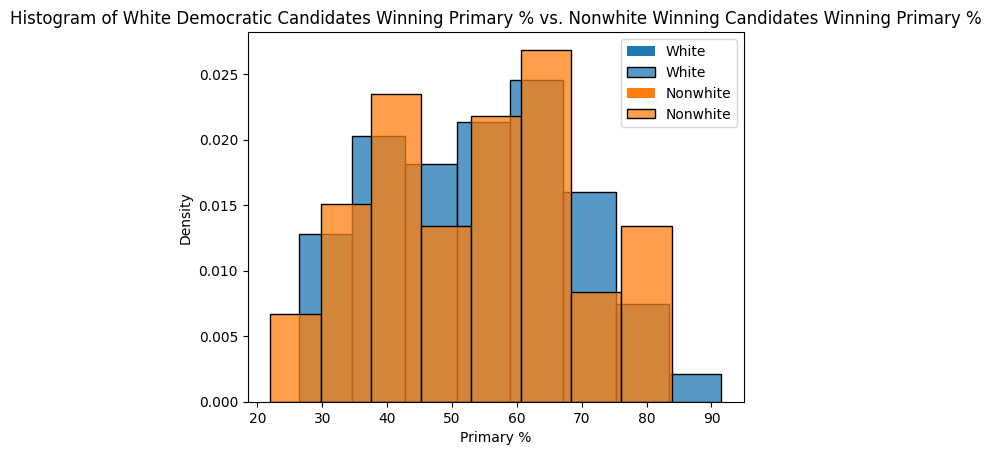

In [ ]:
sns.histplot(win_dem.query("Race == 'White'")["Primary %"], label="White", stat="density")
sns.histplot(win_dem.query("Race != 'White'")["Primary %"], label="Nonwhite", stat="density")
plt.title("Histogram of White Democratic Candidates Winning Primary % vs. Nonwhite Winning Candidates Winning Primary %")
plt.legend()

### Figure 4

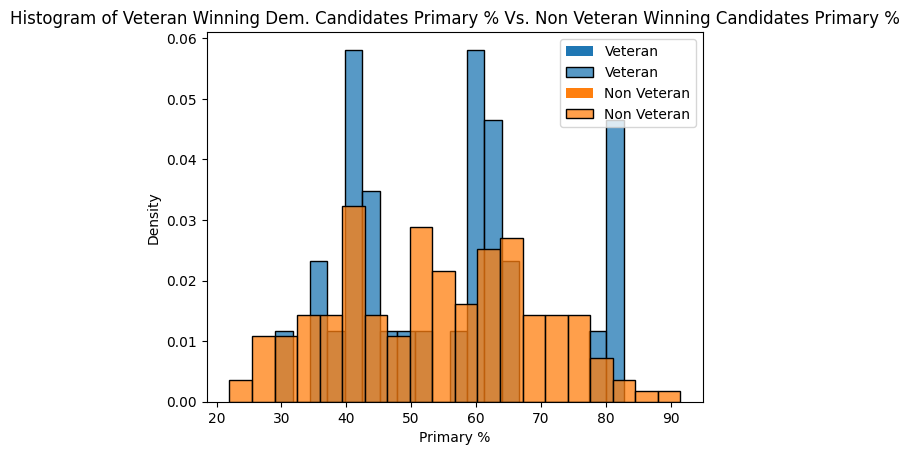

In [ ]:
sns.histplot(win_dem[win_dem['Veteran?'] == 'Yes']["Primary %"], label="Veteran", stat="density", bins=20)
sns.histplot(win_dem[win_dem['Veteran?'] != 'Yes']["Primary %"], label="Non Veteran", stat="density", bins=20)
plt.title("Histogram of Veteran Winning Dem. Candidates Primary % Vs. Non Veteran Winning Candidates Primary %")
plt.legend()

In [ ]:
X_nn = win_dem_grps[['partisan_lean', 'is_nonwhite', 'is_female', 'elected_official']]
y_nn = win_dem_grps['primary']

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_nn_train_scaled = scaler.fit_transform(X_train_nn)
X_nn_test_scaled = scaler.fit_transform(X_test_nn)

X_train_tensor = torch.tensor(X_nn_train_scaled).to(torch.float32)
y_train_tensor = torch.tensor(y_train_nn.values).to(torch.float32)
X_test_tensor = torch.tensor(X_nn_test_scaled).to(torch.float32)
y_test_tensor = torch.tensor(y_test_nn.values).to(torch.float32)

input_size = X_train_tensor.shape[1]
output_size = 1
hidden_1 = 64
hidden_2 = 8 

nn_model = nn.Sequential(
    nn.Linear(input_size, hidden_1), 
    nn.ReLU(),
    nn.Linear(hidden_1, hidden_2),
    nn.ReLU(),
    nn.Linear(hidden_2, output_size)
)

criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

num_epochs = 1000 
for epoch in range(num_epochs):
    optimizer.zero_grad() #reset the gradients
    predictions = nn_model(X_train_tensor)
    loss = criterion(predictions,y_train_tensor)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    nn_model.eval()
    y_pred_tensor = nn_model(X_test_tensor)
    y_pred = y_pred_tensor.flatten().numpy()

nn_rmse = np.sqrt(mean_squared_error(y_test_nn, y_pred))
nn_rmse

/shared-libs/python3.10/py/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([153])) that is different to the input size (torch.Size([153, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


17.881780129085865

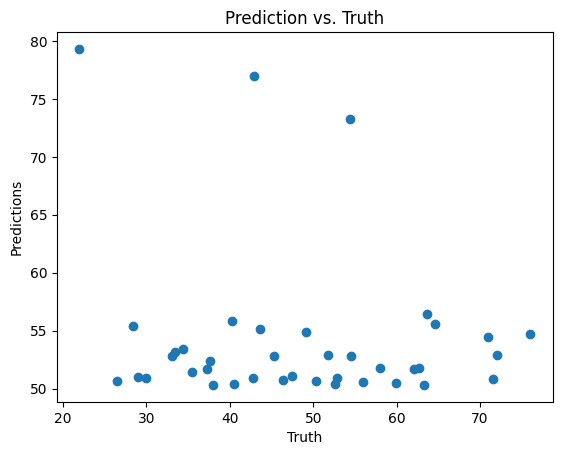

In [ ]:
plt.scatter(y_test_nn, y_pred)
plt.xlabel("Truth")
plt.ylabel("Predictions")
plt.title("Prediction vs. Truth")
plt.show()

In [ ]:
nn_mse = np.sqrt(mean_squared_error(y_test_nn, y_pred))
test["prediction"] = glm_model.predict(sm.add_constant(test))
print("GLM RMSE: ", np.sqrt(np.mean((test["primary"] - test["prediction"])**2)))
print("NN RMSE", nn_mse)

GLM RMSE:  15.844639689117617
NN RMSE 17.45400774518874
/shared-libs/python3.10/py/lib/python3.10/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in reduce
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Relationships and Trends

### Figure 1

Shown in figure 1 is the relationship between the regional Partisan Lean (which represents the extremity of a region's voting habits) and the primary election support percentage of the winning candidate. Due to complications in the data set only Democratic candidates are shown. In the figure there exists a somewhat negative linear relationship between these variables indicating a relationship between a regions partisan lean and the winning candidate's primary support, which is the subject in question. This plot also highlights the various offices in the dataset and shows a similar relationship between all the offices in the dataset.

### Figure 2

This plot highlights the difference of relationship's between White and Non-White candidates and illustrates that first of all the majority of the outliers on the right hand side of the plot are Non-White candidates and secondly there exists a flatter relationship for Non-White candidates which might yield insignificant results in a regression. The White candidates however appear to have a much stronger and steeper relationship and would likely yield significant results. In further analysis the race of the candidate will likely create very different outcomes and we will be including this in our analysis as something to control for or remove.

### Figure 3

This plot shows the distributions of primary support in percent by race, White or Non-White. These distributions are somewhat equivalent and highlights the similiraities between the two variables despite the difference in relationship shown in the prior figure. This plot also shows the range of values for winning democratic candidates which range from about 20 to 90 percent. This plot indicates no systematic differences in the populations to account for in further analysis and should allow us to run simpler models.

### Figure 4

Shown in Figure 4 is the distribution of primary support for Veteran and Non-Veteran candidates. This figure highlights that the distribution of primary support is effectively the same for Veteran and Non-Veteran candidates despite the peaks in the distribution which arises from the small number of Veteran candidates. This plot also shows that the peaks in the veterans dataset are usually found in the non-veterans dataset reinforcing the assumptions made about the small number of veteran candidates. This plot tells us that being a veteran effectively has no systematic effect on the level of support a candidate receives and indicates that being a veteran is something that might be somewhat unnecessary to control in our models. 

# Prediction with GLM's and Nonparametric Methods

### Methods

We are trying to predict the primary winning % for democrats that won their respective primary elections. The features we used were partisan lean of the region the candidate was from, and a one-hot encoding of the following categorical variables: white and male, non-white and male, white and female, nonwhite and female. 

We used a neural network as the nonparametric method. The neural network has an input layer that is the number of features we have, a hidden layer that will have as many nodes as the mean of the input and output layers, and an output layer of 1 which is just the regression. ReLU is used as the activation function, our loss function is MSE, and we use the Adam optimizer as our optimizer. The data is split into a training and test split then trained on 1000 epochs where it is optimized and then evaluated for its MSE. The model assumes the relationship with the data is approximately linear. We use MSE to evaluate the model's performance. 

### Results 

Our neural network gave an MSE of 1464.22. Then when a scatter plot of the predictions to the truth showed the model underpredicted a lot showing there is some kind of systemic bias or error within the model. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=690ae071-0a20-4f1c-a62a-964deb259c61' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>